# Import TESS light curves into HATS catalog

## Install deps

In [1]:
%pip install -U lsdb hats-import

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 85.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 125.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 158.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 187.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 175.4 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 136.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 92.3 MB/s  0:00:00
  Attempting uninstall: dask━━╸━━━━━━━━━━━━━━━━━ 12/21 [numba]ic]
    Found existing installation: dask 2025.9.1━━━━━━━━━━━━━━━━ 12/21 [numba]
    Uninstalling dask-2025.9.1:━╸━━━━━━━━━━━━━━━ 13/21 [dask]
      Successfully uninsta

## Imports

For this notebook we need
- `os`
- `upath`
- `collections`
- `datetime`
- `numpy`
- `tqdm`
- `pyarrow`
- `astropy`
- `hats_import`
- `lsdb`

In [1]:
import os
from upath import UPath
from collections import defaultdict
from datetime import datetime
from tqdm.auto import tqdm

import numpy as np
import pyarrow as pa
from astropy.io import fits
from astropy.table import Table
from hats_import.catalog.file_readers import InputReader
from hats_import import CollectionArguments
import lsdb


SH_ROOT = "./sh_files" # Path to cURL scripts

/opt/envs/python3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download all TESS Light Curve cURL scripts, one per sector

In [4]:
# This cell only needs to be run once, or if there are new sectors to download. 
# If the cURL scripts are already there, skip it!
curl_root = UPath("https://archive.stsci.edu/missions/tess/download_scripts/sector")
LAST_SECTOR = 96

def download_sh_files():
    sh_root_path = UPath(SH_ROOT)
    sh_root_path.mkdir(exist_ok=True, parents=True)
    
    for sector in tqdm(range(1, LAST_SECTOR+1)):
        fname = f"tesscurl_sector_{sector}_lc.sh"
        sh_remote = curl_root / fname
        sh_local = sh_root_path / fname
        with sh_local.open("wb") as local:
            local.write(sh_remote.read_bytes())


download_sh_files()

100%|██████████| 96/96 [00:33<00:00,  2.91it/s]


## Create custom HATS-import reader class

In [2]:
sh_paths = sorted(upath.path for upath in UPath(SH_ROOT).glob("*.sh"))
s3_root = "s3://stpubdata/tess/public/tid"

def slashfill(tic_str):
    assert len(tic_str) == 16
    result = "/".join(tic_str[i:i+4] for i in range(0, len(tic_str), 4))
    return result

def convert_uri(file_uri, return_id=True):
    filename = os.path.basename(file_uri)
    fname_list = filename.split("-")
    sector_str = fname_list[1]
    tic_str = fname_list[2]

    meta_path = sector_str + "/" + slashfill(tic_str)
    s3_uri = UPath(
        s3_root + "/" + meta_path + "/" + filename,
        anon=True
    )
    if return_id:
        return s3_uri, "tic" + "_".join([tic_str, sector_str])
    return s3_uri

def get_uris(lines, return_id):
    """
    Given the lines from a TESS cURL script, convert the file URIs (which
    currently point to STScI on-prem storage) to s3 cloud URIs. The cURL scripts
    will soon be replaced with s3 URIs, so this step will become obsolete.
    """
    uris = []
    
    for l in lines[1:]:
        cmds = l.split()
        uri = convert_uri(cmds[-1], return_id=return_id)
        uris.append(uri)
    
    return uris


class TESSLCReader(InputReader):
    header0_columns = {
        "RA_OBJ": pa.float64(),
        "DEC_OBJ": pa.float64(),
        "TSTART": pa.float32(),
        "TSTOP": pa.float32(),
        "DATE-OBS": pa.timestamp("ms", tz="utc"),
        "DATE-END": pa.timestamp("ms", tz="utc"),
        "TICID": pa.int64(),
        "SECTOR": pa.int32(),
        "CAMERA": pa.int8(),
        "CCD": pa.int8(),
        "PMRA": pa.float32(),
        "PMDEC": pa.float32(),
        "PMTOTAL": pa.float32(),
        "TEFF": pa.float32(),
        "LOGG": pa.float32(),
        "MH": pa.float32(),
        "RADIUS": pa.float32(),
    }

    header1_columns = {
        "EXPOSURE": pa.float32(),
        "TELAPSE": pa.float32(),
        "DEADC": pa.float32(),
        "TIMEPIXR": pa.float32(),
        "TIERRELA": pa.float32(),
        "INT_TIME": pa.float32(),
        "READTIME": pa.float32(),
        "FRAMETIM": pa.float32(),
        "NUM_FRM": pa.int32(),
        "TIMEDEL": pa.float32(),
        "GAINA": pa.float32(),
        "GAINB": pa.float32(),
        "GAINC": pa.float32(),
        "GAIND": pa.float32(),
        "READNOIA": pa.float32(),
        "READNOIB": pa.float32(),
        "READNOIC": pa.float32(),
        "READNOID": pa.float32(),
        "NREADOUT": pa.int32(),
        "CDPP0_5": pa.float32(),
        "CDPP1_0": pa.float32(),
        "CDPP2_0": pa.float32(),
        "CROWDSAP": pa.float32(),
        "FLFRCSAP": pa.float32(),
        "PDCVAR": pa.float32(),
        "PR_GOOD1": pa.float32(),
        "PR_WGHT1": pa.float32(),
        "PR_GOOD2": pa.float32(),
        "PR_WGHT2": pa.float32(),
        "PR_GOOD3": pa.float32(),
        "PR_WGHT3": pa.float32(),
        "PDC_TOT":  pa.float32(),
        "PDC_TOTP": pa.float32(),
        "PDC_COR": pa.float32(),
        "PDC_CORP":pa.float32(),
        "PDC_VAR":pa.float32(),
        "PDC_VARP": pa.float32(),
        "PDC_NOI": pa.float32(),
        "PDC_NOIP": pa.float32(),
        "PDC_EPT":pa.float32(),
        "PDC_EPTP": pa.float32(),
    }

    header2_columns = {
        "NPIXSAP": pa.int32(),
        "NPIXMISS": pa.int32(),
    }

    def __init__(self, chunksize: int = 100, few_rows_per_sector: bool = False):
        super().__init__()
        self.chunksize = chunksize
        self.few_rows_per_sector = few_rows_per_sector 
    
    @staticmethod
    def fits_to_hats_colname(name: str) -> str:
        return name.lower().replace("-", "_")
    
    def read(self, input_file: str, read_columns=None):
        uris = self.get_uris_from_sh(input_file)

        if self.few_rows_per_sector:
            uris = uris[:90]

        n_chunks = int(np.ceil(len(uris) / self.chunksize))
        
        for chunk in np.array_split(uris, n_chunks):
            # Just ra and dec are needed
            if read_columns is None:
                yield self.get_whole_table(chunk)
            else:
                yield self.get_ra_dec_table(chunk, read_columns)

    def get_ra_dec_table(self, uris, columns):
        ra_, dec_ = [], []
        for upath in uris:
            ra, dec = self.get_radec_from_path(upath)
            ra_.append(ra)
            dec_.append(dec)
        return pa.table(dict(zip(columns, [ra_, dec_], strict=True)))

    def get_whole_table(self, uris):
        data = defaultdict(list)
        for path in uris:
            with path.open('rb') as fh, fits.open(fh) as hdul:
                # Adding values from headers
                self.add_header_values(data, hdul[0].header, self.header0_columns)
                self.add_header_values(data, hdul[1].header, self.header1_columns)
                self.add_header_values(data, hdul[2].header, self.header2_columns)

                # Adding light curve
                data['lightcurve'].append(self.fits_table_to_pa_scalar(hdul[1].data))

                # Adding aperture and its shape
                ap, ap_x, ap_y = self.parse_fist_aperture(hdul[2].data)
                data['aperture'].append(ap)
                data['aperture_size_x'].append(ap_x)
                data['aperture_size_y'].append(ap_y)
        table = pa.table(data)
        return table

    def add_header_values(self, data, header, columns):
        for fits_colname, ty in columns.items():
            hats_colname = self.fits_to_hats_colname(fits_colname)
            value = header.get(fits_colname)
            if pa.types.is_timestamp(ty):
                value = datetime.fromisoformat(value)
            elif pa.types.is_floating(ty):
                if value is not None and np.isnan(value):
                    value = None
            data[hats_colname].append(pa.scalar(value, type=ty))
        
    @staticmethod
    def fits_table_to_pa_scalar(arr):
        data = {}
        for fits_field, (fits_dtype, _) in arr.dtype.fields.items():
            hats_field = TESSLCReader.fits_to_hats_colname(fits_field)
            # Swap bytes to "native" order
            hats_dtype = fits_dtype.newbyteorder('=')
            data[hats_field] = np.asarray(arr[fits_field], dtype=hats_dtype)
        return pa.scalar(data)
        
    def get_radec_from_path(self, path):
        with path.open('rb') as fh:
            header = fits.getheader(fh, 0)
        return header.get('RA_OBJ'), header.get('DEC_OBJ')
    
    def get_uris_from_sh(self, sh_file):
        with open(sh_file) as fh:
            return get_uris(fh.readlines(), return_id=False)

    @staticmethod
    def parse_fist_aperture(data):
        dtype = data.dtype.newbyteorder("=")
        flat_array = np.asarray(data.flatten(), dtype=dtype)
        return (
            pa.scalar(flat_array),
            pa.scalar(data.shape[1], type=pa.int16()),
            pa.scalar(data.shape[0], type=pa.int16()),
        )

## Define default columns and pipeline arguments

In [3]:
default_columns = [
    'ra_obj',
    'dec_obj',
    'ticid',
    'sector',
    # CHANGE TO SUBCOLUMNS
    # 'lightcurve.time',
    # 'lightcurve.pdcsap_flux',
    # 'lightcurve.pdcsap_flux_err',
    # 'lightcurve.quality',
    'lightcurve',
]

args = (
    CollectionArguments(
        output_artifact_name="tess-lightcurve",
        output_path="hats",
    )
    .catalog(
        # CHANGE TO USE ALL SECTORS
        input_file_list=sh_paths,
        # REMOVE few_rows_per_sector=True
        file_reader=TESSLCReader(chunksize=100, few_rows_per_sector=True),
        ra_column="ra_obj",
        dec_column="dec_obj",
        sort_columns="ticid",
        highest_healpix_order=7,
        pixel_threshold=200,
        addl_hats_properties={
            'hats_cols_default': default_columns,
        },
    )
    # UNCOMMENT MARGINS
     .add_margin(margin_threshold=10.0, is_default=True)
    #.add_margin(margin_threshold=60.0)
    .add_index(indexing_column="ticid", include_healpix_29=True)
)

## Run the import pipeline

In [4]:
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client, pipeline


with Client(n_workers=os.cpu_count(), threads_per_worker=2, memory_limit=None) as client:
    display(client)
    pipeline_with_client(args, client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /jupyter/user/zclaytor/proxy/8787/status,
Dashboard: /jupyter/user/zclaytor/proxy/8787/status,Workers: 16
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43265,Workers: 16
Dashboard: /jupyter/user/zclaytor/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46549,Total threads: 2
Dashboard: /jupyter/user/zclaytor/proxy/34977/status,Memory: 0 B
Nanny: tcp://127.0.0.1:37029,


Finishing : 100%|██████████| 4/4 [00:00<00:00, 41.11it/s]
2025-10-16 16:11:45,521 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bb0f9538a7c1bc48090ce704dd262529 initialized by task ('shuffle-transfer-bb0f9538a7c1bc48090ce704dd262529', 89) executed on worker tcp://127.0.0.1:34881
2025-10-16 16:11:46,704 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bb0f9538a7c1bc48090ce704dd262529 deactivated due to stimulus 'task-finished-1760631106.70316'
2025-10-16 16:11:47,223 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bb0f9538a7c1bc48090ce704dd262529 initialized by task ('shuffle-transfer-bb0f9538a7c1bc48090ce704dd262529', 79) executed on worker tcp://127.0.0.1:40167
2025-10-16 16:11:48,192 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bb0f9538a7c1bc48090ce704dd262529 deactivated due to stimulus 'task-finished-1760631108.1903033'
2025-10-16 16:11:48,453 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle bb0f9538a7c1bc48090ce704dd26

## Inspect the HATS catalog

In [5]:
tess = lsdb.open_catalog('hats/tess-lightcurve')
tess.head()

ra_obj   dec_obj      ticid  sector  \
_healpix_29                                                
105786848131093    45.35759  0.951419  377057679      31   
2571916076391507  43.229748  4.065909  328224468       4   
2986042224731346  40.235815  4.870716  318754598       4   
3441046419832897   44.89577  5.685514  347551041       4   
4583882201807729  51.251165   5.61768  381188642       4   

                                                         lightcurve  
_healpix_29                                                          
105786848131093   [{cadenceno: 660279, mom_centr1: NaN, mom_cent...  
2571916076391507  [{cadenceno: 132081, mom_centr1: 1544.802554, ...  
2986042224731346  [{cadenceno: 132081, mom_centr1: 1988.095261, ...  
3441046419832897  [{cadenceno: 132081, mom_centr1: 1181.929337, ...  
4583882201807729  [{cadenceno: 132081, mom_centr1: 116.576586, m...

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - tess-lightcurve'}>)

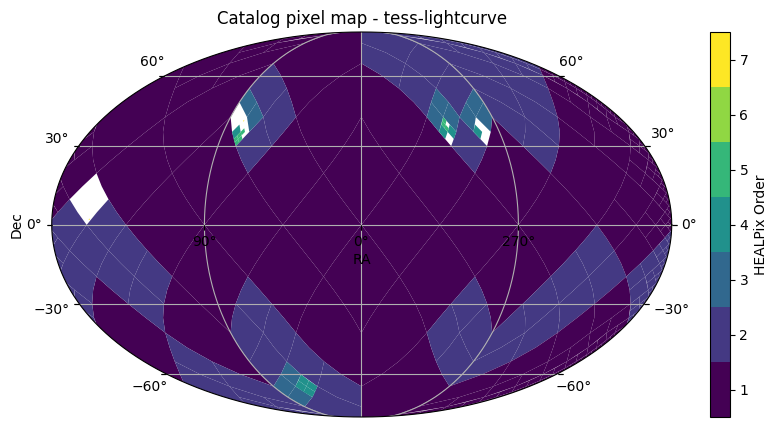

In [6]:
tess.plot_pixels()